In [1]:
from graphmodels.graphmodel import converte_to_format, GraphModel, concatenate_graph_specs
from database import select_dataset
from graphmodels.utils import get_X_y_from_data
from graphmodels.validation import score_model, plot_diagnostic
import pandas as pd

In [2]:
from models.Hermen.model_BE2 import BE2_models

In [3]:

fbs_data = select_dataset('foodbalancesheet')
population_data = select_dataset('population')
crops_data = select_dataset('crops')
landuse = select_dataset('landuse')

In [4]:
model_df = pd.concat([fbs_data, population_data, crops_data],).dropna(subset=['Variable'])

In [5]:
from graphmodels.utils import df_to_data_dict

def get_X_y_from_data(model, data_dict):
    '''TO CLEAN UP'''
    X = {key: data_dict[key] for key in model.inputs_() + model.parameters_()}
    y = {key: data_dict[key] for key in model.variables_() + model.outputs_() if key in data_dict}
    return X, y


def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code]
    return X


def fill_missing_values(df):
    return df


def df_to_data_dict(df, itemized):
    data_dict = {}

    non_item_df = df[~df.Variable.isin(itemized)].pivot(
        index=['ISO', 'Year'], columns='Variable', values='Value')
    non_item_df = fill_missing_values(non_item_df)
    
    if itemized != []:
        item_df = df[df.Variable.isin(itemized)].pivot(
            index=['ISO', 'Year', 'Item'], columns='Variable', values='Value')
        data_dict.update(df_to_dict(item_df))


    data_dict.update(df_to_dict(non_item_df))

    return data_dict


itemized = [
    'FDKCi', 'FPi', 'FIi', 'SVi', 'FEi', 'Domestic supply quantity',
    'FDi', 'SDi', 'FLOi', 'PDi', 'RDi', 'Food', 'FDKGi', 'NFDi',
    'SSRi', 'KKRi', 'TCLDi', 'CYi'
    ]

data_dict = df_to_data_dict(model_df, itemized)


data_dict.update(df_to_data_dict(landuse, itemized=[]))
data_dict['CL_baseline'] = data_dict['CL'] 
data_dict['IL_baseline'] = data_dict['IL'] 
data_dict['FL_baseline'] = data_dict['FL'] 
data_dict['R_rate'] = 0


In [6]:
from graphmodels.utils import get_X_y_from_data
X, y_true = get_X_y_from_data(BE2_models['TCLDi_model'], data_dict)

score_model(BE2_models['TCLDi_model'], X, y_true)

FPi
TCLDi


,r2,correlation,rmse,Variable
0,1.000000,1.000000,3.333132e+01,FPi
1,0.993083,0.997947,3.083538e+11,TCLDi


In [7]:
X, y_true = get_X_y_from_data(BE2_models['IL_FL_model'], data_dict)

score_model(BE2_models['IL_FL_model'], X, y_true)

IL
FL


,r2,correlation,rmse,Variable
0,1.0,1.0,0.0,IL
1,1.0,1.0,0.0,FL


In [8]:
X, y_true = get_X_y_from_data(BE2_models['BE2_model'], data_dict)

score_model(BE2_models['BE2_model'], X, y_true)

FL
IL
CL
TCLDi
FPi


,r2,correlation,rmse,Variable
0,0.948673,0.974597,4.045514e+08,FL
1,-47.793481,0.720319,6.594513e+08,IL
2,-0.228746,0.267987,5.977774e+08,CL
3,0.993083,0.997947,3.083538e+11,TCLDi
4,1.000000,1.000000,3.333132e+01,FPi


In [10]:
res = BE2_models['BE2_model'].run(X)

In [13]:
res['TCLDi'].groupby(level=['ISO', 'Year']).sum()

ISO  Year
AFG  1961         0.000000
     1962         0.000000
     1963         0.000000
     1964         0.000000
     1965         0.000000
                 ...      
ZWE  2015    345850.174138
     2016    451517.423549
     2017    316234.217933
     2018    344889.576251
     2019         0.000000
Length: 10773, dtype: float64

In [16]:
res = BE2_models['BE2_model'].run(X)

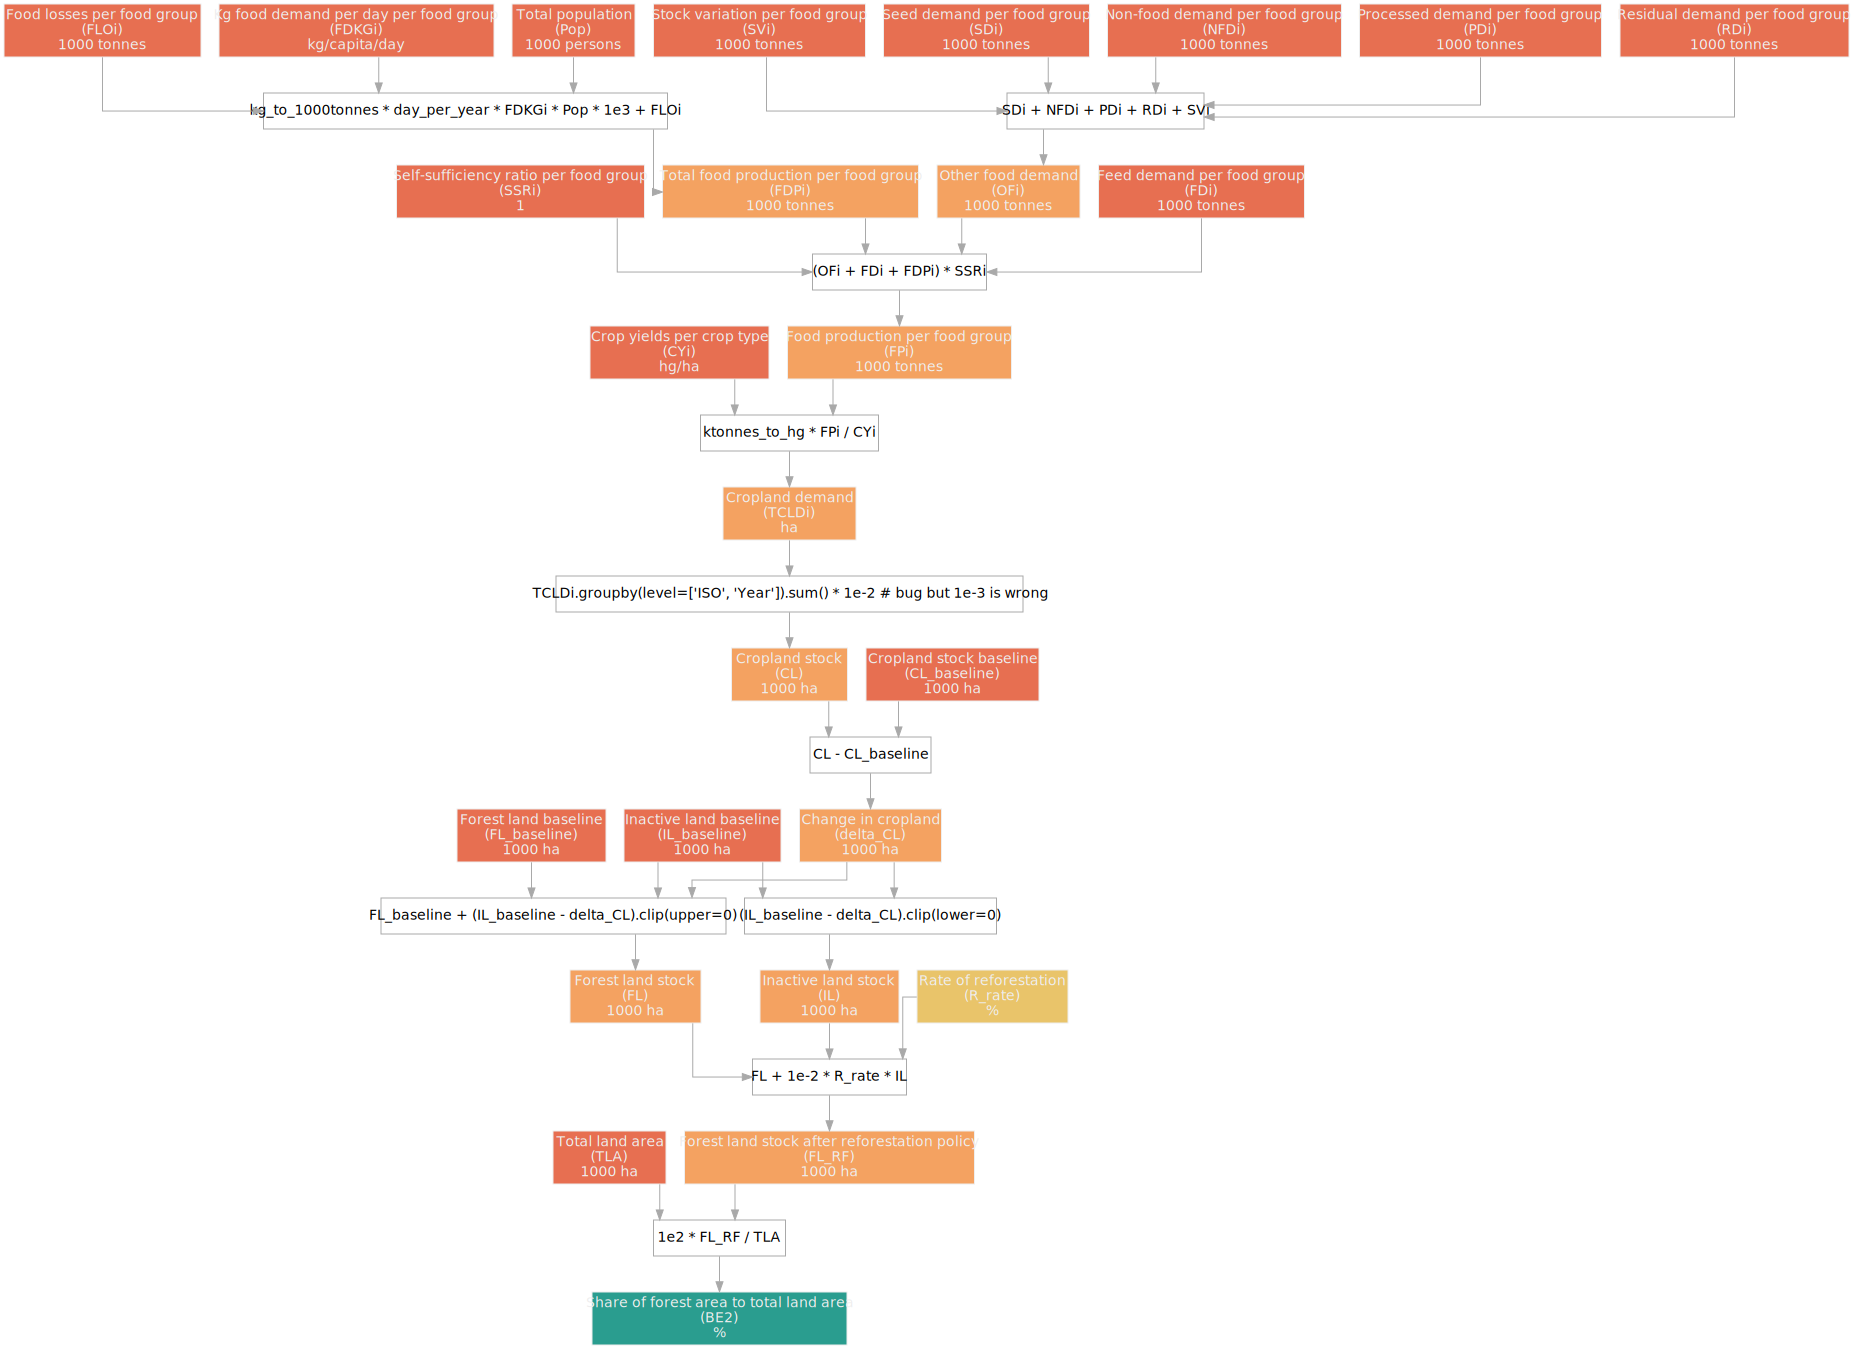

In [21]:
BE2_models['BE2_model'].draw()

In [23]:
{ 'RDi': {
                'type': 'input',
                'unit': '1000 tonnes',
                'name': 'Residual demand per food group'
                },}

{'RDi': {'type': 'input',
  'unit': '1000 tonnes',
  'name': 'Residual demand per food group'}}